In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model

In [66]:
import tensorflow as tf
import numpy as np
import os
from numpy import genfromtxt
from keras import backend as K
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.core import Lambda, Flatten, Dense

def conv2d_bn(x,
              layer=None,
              cv1_out=None,
              cv1_filter=(1, 1),
              cv1_strides=(1, 1),
              cv2_out=None,
              cv2_filter=(3, 3),
              cv2_strides=(1, 1),
              padding=None):
    num = '' if cv2_out == None else '1'
    tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, data_format='channels_first', name=layer+'_conv'+num)(x)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
    tensor = Activation('relu')(tensor)
    if padding == None:
        return tensor
    tensor = ZeroPadding2D(padding=padding, data_format='channels_first')(tensor)
    if cv2_out == None:
        return tensor
    tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, data_format='channels_first', name=layer+'_conv'+'2')(tensor)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
    tensor = Activation('relu')(tensor)
    return tensor

def inception_block_1a(X):
    """
    Implementation of an inception block
    """
    
    X_3x3 = Conv2D(96, (1, 1), data_format='channels_first', name ='inception_3a_3x3_conv1')(X)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name = 'inception_3a_3x3_bn1')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    X_3x3 = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_3x3)
    X_3x3 = Conv2D(128, (3, 3), data_format='channels_first', name='inception_3a_3x3_conv2')(X_3x3)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_3x3_bn2')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    
    X_5x5 = Conv2D(16, (1, 1), data_format='channels_first', name='inception_3a_5x5_conv1')(X)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_5x5_bn1')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)
    X_5x5 = ZeroPadding2D(padding=(2, 2), data_format='channels_first')(X_5x5)
    X_5x5 = Conv2D(32, (5, 5), data_format='channels_first', name='inception_3a_5x5_conv2')(X_5x5)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_5x5_bn2')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)

    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = Conv2D(32, (1, 1), data_format='channels_first', name='inception_3a_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=((3, 4), (3, 4)), data_format='channels_first')(X_pool)

    X_1x1 = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3a_1x1_conv')(X)
    X_1x1 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_1x1_bn')(X_1x1)
    X_1x1 = Activation('relu')(X_1x1)
        
    # CONCAT
    inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)

    return inception

def inception_block_1b(X):
    X_3x3 = Conv2D(96, (1, 1), data_format='channels_first', name='inception_3b_3x3_conv1')(X)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_3x3_bn1')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    X_3x3 = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_3x3)
    X_3x3 = Conv2D(128, (3, 3), data_format='channels_first', name='inception_3b_3x3_conv2')(X_3x3)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_3x3_bn2')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)

    X_5x5 = Conv2D(32, (1, 1), data_format='channels_first', name='inception_3b_5x5_conv1')(X)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_5x5_bn1')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)
    X_5x5 = ZeroPadding2D(padding=(2, 2), data_format='channels_first')(X_5x5)
    X_5x5 = Conv2D(64, (5, 5), data_format='channels_first', name='inception_3b_5x5_conv2')(X_5x5)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_5x5_bn2')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)

    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    X_pool = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3b_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=(4, 4), data_format='channels_first')(X_pool)

    X_1x1 = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3b_1x1_conv')(X)
    X_1x1 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_1x1_bn')(X_1x1)
    X_1x1 = Activation('relu')(X_1x1)

    inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)

    return inception

def inception_block_1c(X):
    X_3x3 = conv2d_bn(X,
                           layer='inception_3c_3x3',
                           cv1_out=128,
                           cv1_filter=(1, 1),
                           cv2_out=256,
                           cv2_filter=(3, 3),
                           cv2_strides=(2, 2),
                           padding=(1, 1))

    X_5x5 = conv2d_bn(X,
                           layer='inception_3c_5x5',
                           cv1_out=32,
                           cv1_filter=(1, 1),
                           cv2_out=64,
                           cv2_filter=(5, 5),
                           cv2_strides=(2, 2),
                           padding=(2, 2))

    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = ZeroPadding2D(padding=((0, 1), (0, 1)), data_format='channels_first')(X_pool)

    inception = concatenate([X_3x3, X_5x5, X_pool], axis=1)

    return inception

def inception_block_2a(X):
    X_3x3 = conv2d_bn(X,
                           layer='inception_4a_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=192,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_5x5 = conv2d_bn(X,
                           layer='inception_4a_5x5',
                           cv1_out=32,
                           cv1_filter=(1, 1),
                           cv2_out=64,
                           cv2_filter=(5, 5),
                           cv2_strides=(1, 1),
                           padding=(2, 2))

    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    X_pool = conv2d_bn(X_pool,
                           layer='inception_4a_pool',
                           cv1_out=128,
                           cv1_filter=(1, 1),
                           padding=(2, 2))
    X_1x1 = conv2d_bn(X,
                           layer='inception_4a_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))
    inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)

    return inception

def inception_block_2b(X):
    #inception4e
    X_3x3 = conv2d_bn(X,
                           layer='inception_4e_3x3',
                           cv1_out=160,
                           cv1_filter=(1, 1),
                           cv2_out=256,
                           cv2_filter=(3, 3),
                           cv2_strides=(2, 2),
                           padding=(1, 1))
    X_5x5 = conv2d_bn(X,
                           layer='inception_4e_5x5',
                           cv1_out=64,
                           cv1_filter=(1, 1),
                           cv2_out=128,
                           cv2_filter=(5, 5),
                           cv2_strides=(2, 2),
                           padding=(2, 2))
    
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = ZeroPadding2D(padding=((0, 1), (0, 1)), data_format='channels_first')(X_pool)

    inception = concatenate([X_3x3, X_5x5, X_pool], axis=1)

    return inception

def inception_block_3a(X):
    X_3x3 = conv2d_bn(X,
                           layer='inception_5a_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=384,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    X_pool = conv2d_bn(X_pool,
                           layer='inception_5a_pool',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           padding=(1, 1))
    X_1x1 = conv2d_bn(X,
                           layer='inception_5a_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))

    inception = concatenate([X_3x3, X_pool, X_1x1], axis=1)

    return inception

def inception_block_3b(X):
    X_3x3 = conv2d_bn(X,
                           layer='inception_5b_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=384,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = conv2d_bn(X_pool,
                           layer='inception_5b_pool',
                           cv1_out=96,
                           cv1_filter=(1, 1))
    X_pool = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_pool)

    X_1x1 = conv2d_bn(X,
                           layer='inception_5b_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))
    inception = concatenate([X_3x3, X_pool, X_1x1], axis=1)

    return inception

def imgRecoModel(input_shape):
    """
    Implementation of the Inception model used for FaceNet
    
    Arguments:
    input_shape -- shape of the images of the dataset
    Returns:
    model -- a Model() instance in Keras
    """
        
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # First Block
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 1, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D((3, 3), strides = 2)(X)
    
    # Second Block
    X = Conv2D(64, (1, 1), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)

    # Second Block
    X = Conv2D(192, (3, 3), strides = (1, 1), name = 'conv3')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)
    
    # Inception 1: a/b/c
    X = inception_block_1a(X)
    X = inception_block_1b(X)
    X = inception_block_1c(X)
    
    # Inception 2: a/b
    X = inception_block_2a(X)
    X = inception_block_2b(X)
    
    # Inception 3: a/b
    X = inception_block_3a(X)
    X = inception_block_3b(X)
    
    # Top layer
    X = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), data_format='channels_first')(X)
    X = Flatten()(X)
    X = Dense(128, name='dense_layer')(X)
    
    # L2 normalization
    X = Lambda(lambda  x: K.l2_normalize(x,axis=1))(X)

    # Create model instance
    model = Model(inputs = X_input, outputs = X, name='ImgRecoModel')
        
    return model

# Unzipping

In [ ]:
# !unzip drive/MyDrive/Finger.zip

# Training

In [14]:
import tensorflow as tf
print(tf.__version__)

2.8.2


In [50]:
import os
from collections import defaultdict
import cv2
import numpy as np
import tensorflow

from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
# from keras.engine.topology import Layer
from tensorflow.keras import layers
from keras import backend as K
K.set_image_data_format('channels_first')
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
# from inception_block_model.py import imgRecoModel

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
def get_data_dic(path, train=True):
    dic_data = defaultdict(list)
    for img in os.listdir(path):
        imgname, ext = os.path.splitext(img)
        ID, etc = imgname.split('__')
        ID = int(ID) - 1
        if train:
            _, lr, finger, _, _ = etc.split('_')
        else:
            _, lr, finger, _ = etc.split('_')
        name = str(ID) + '_' + lr + '_' + finger
        dic_data[name].append(os.path.join(path, img))
    return dic_data

In [52]:
altered_path = 'SOCOFing/Altered/Altered'
real_path = 'SOCOFing/Real'

dic_alt_easy = get_data_dic(altered_path + '-Easy')
dic_alt_hard = get_data_dic(altered_path + '-Hard')
dic_alt_med = get_data_dic(altered_path + '-Medium')
dic_real = get_data_dic(real_path, train=False)

In [53]:
def merge_data(dic1, dic2, dic3):
    
    for k2, v2 in dic2.items():
        dic1[k2] = dic1[k2] + v2
        
    for k3, v3 in dic3.items():
        dic1[k3] = dic1[k3] + v3
        
    return dic1

In [54]:
dic_data = merge_data(dic_alt_easy, dic_alt_hard, dic_alt_med)

In [55]:
ids = list(dic_data.keys())
len(ids)

6000

In [56]:
def get_train_data(ids, dic_data):
  while True:
    [id_ap, id_n] = np.random.choice(ids, size=2, replace=False)
    [anc_img, pos_img] = np.random.choice(dic_data[id_ap], size=2, replace=False)
    neg_img = np.random.choice(dic_data[id_n], replace=False)

    anc_img = np.around(np.transpose(cv2.resize(cv2.imread(anc_img), (96, 96))/255.0, (2, 0, 1)), decimals=6)
    pos_img = np.around(np.transpose(cv2.resize(cv2.imread(pos_img), (96, 96))/255.0, (2, 0, 1)), decimals=6)
    neg_img = np.around(np.transpose(cv2.resize(cv2.imread(neg_img), (96, 96))/255.0, (2, 0, 1)), decimals=6)

    yield [anc_img, pos_img, neg_img]

In [57]:
def get_batch_data(batch_size, ids, dic_data):

  gen = get_train_data(ids, dic_data)
  x_train = np.zeros((batch_size, 2, 3, 96, 96))
  y_train = np.zeros((batch_size, 1))

  while True:
    for i in range(1, batch_size, 2):
      anc_img, pos_img, neg_img = next(gen)
      x_train[i-1, 0, :, :, :] = anc_img
      x_train[i-1, 1, :, :, :] = pos_img
      y_train[i-1, :] = 1
      x_train[i, 0, :, :, :] = anc_img
      x_train[i, 1, :, :, :] = neg_img
      y_train[i, :] = 0

    x_data = {
        'first_input': x_train[:, 0, :, :, :],
        'second_input': x_train[:, 1, :, :, :]
    }
    yield (x_data, y_train)

In [58]:
def draw_data(num):
  gen = get_batch_data(num, ids, dic_data)
  x, y = next(gen)
  x1 = np.transpose(x['first_input'], (0, 2, 3, 1))
  x2 = np.transpose(x['second_input'], (0, 2, 3, 1))
  fig, ax = plt.subplots(num, 2, figsize=(10, 20))
  for i in range(num):
    ax[i][0].imshow(x1[i])
    ax[i][1].imshow(x2[i])
    if y[i] == 1:
      ax[i][0].title.set_text('Anchor')
      ax[i][1].title.set_text('Positive')
    else:
      ax[i][0].title.set_text('Anchor')
      ax[i][1].title.set_text('Negative')
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

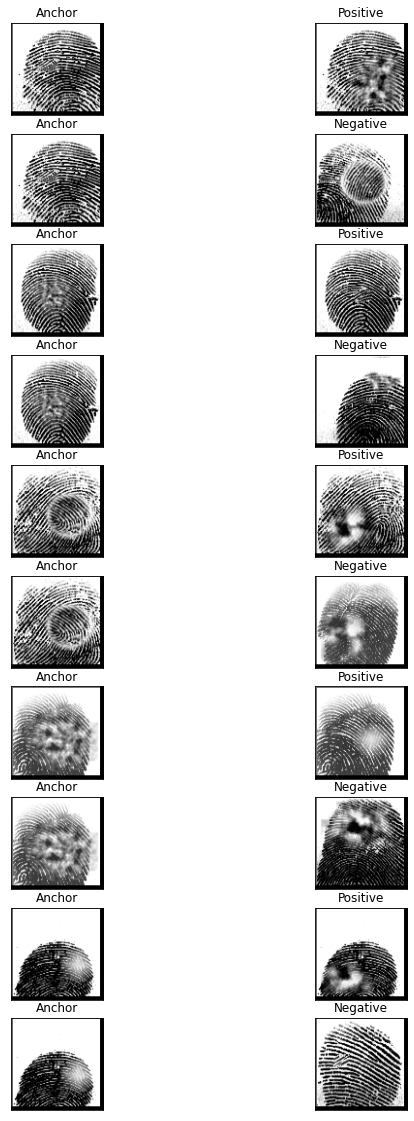

In [59]:
draw_data(10)

In [60]:
batch_size = 32
train_gen = get_batch_data(batch_size, ids, dic_data)

In [61]:
def euclidean_distance(vects):
  x, y = vects
  sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

def euc_dist_out_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

def build_network(network, input_shape):
  f_inp = Input(input_shape, name='first_input')
  s_inp = Input(input_shape, name='second_input')

  f_enc = network(f_inp)
  s_enc = network(s_inp)

  output_layer = Lambda(euclidean_distance, output_shape=euc_dist_out_shape)([f_enc, s_enc])
  model = Model(inputs=[f_inp, s_inp], outputs=output_layer)
  return model

In [62]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true, y_pred):
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
  return contrastive_loss

In [67]:
input_shape = (3, 96, 96)
network = imgRecoModel(input_shape)
siam_network = build_network(network, input_shape)
siam_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 first_input (InputLayer)       [(None, 3, 96, 96)]  0           []                               
                                                                                                  
 second_input (InputLayer)      [(None, 3, 96, 96)]  0           []                               
                                                                                                  
 ImgRecoModel (Functional)      (None, 128)          3743280     ['first_input[0][0]',            
                                                                  'second_input[0][0]']           
                                                                                                  
 lambda_1 (Lambda)              (None, 1)            0           ['ImgRecoModel[0][0]',       

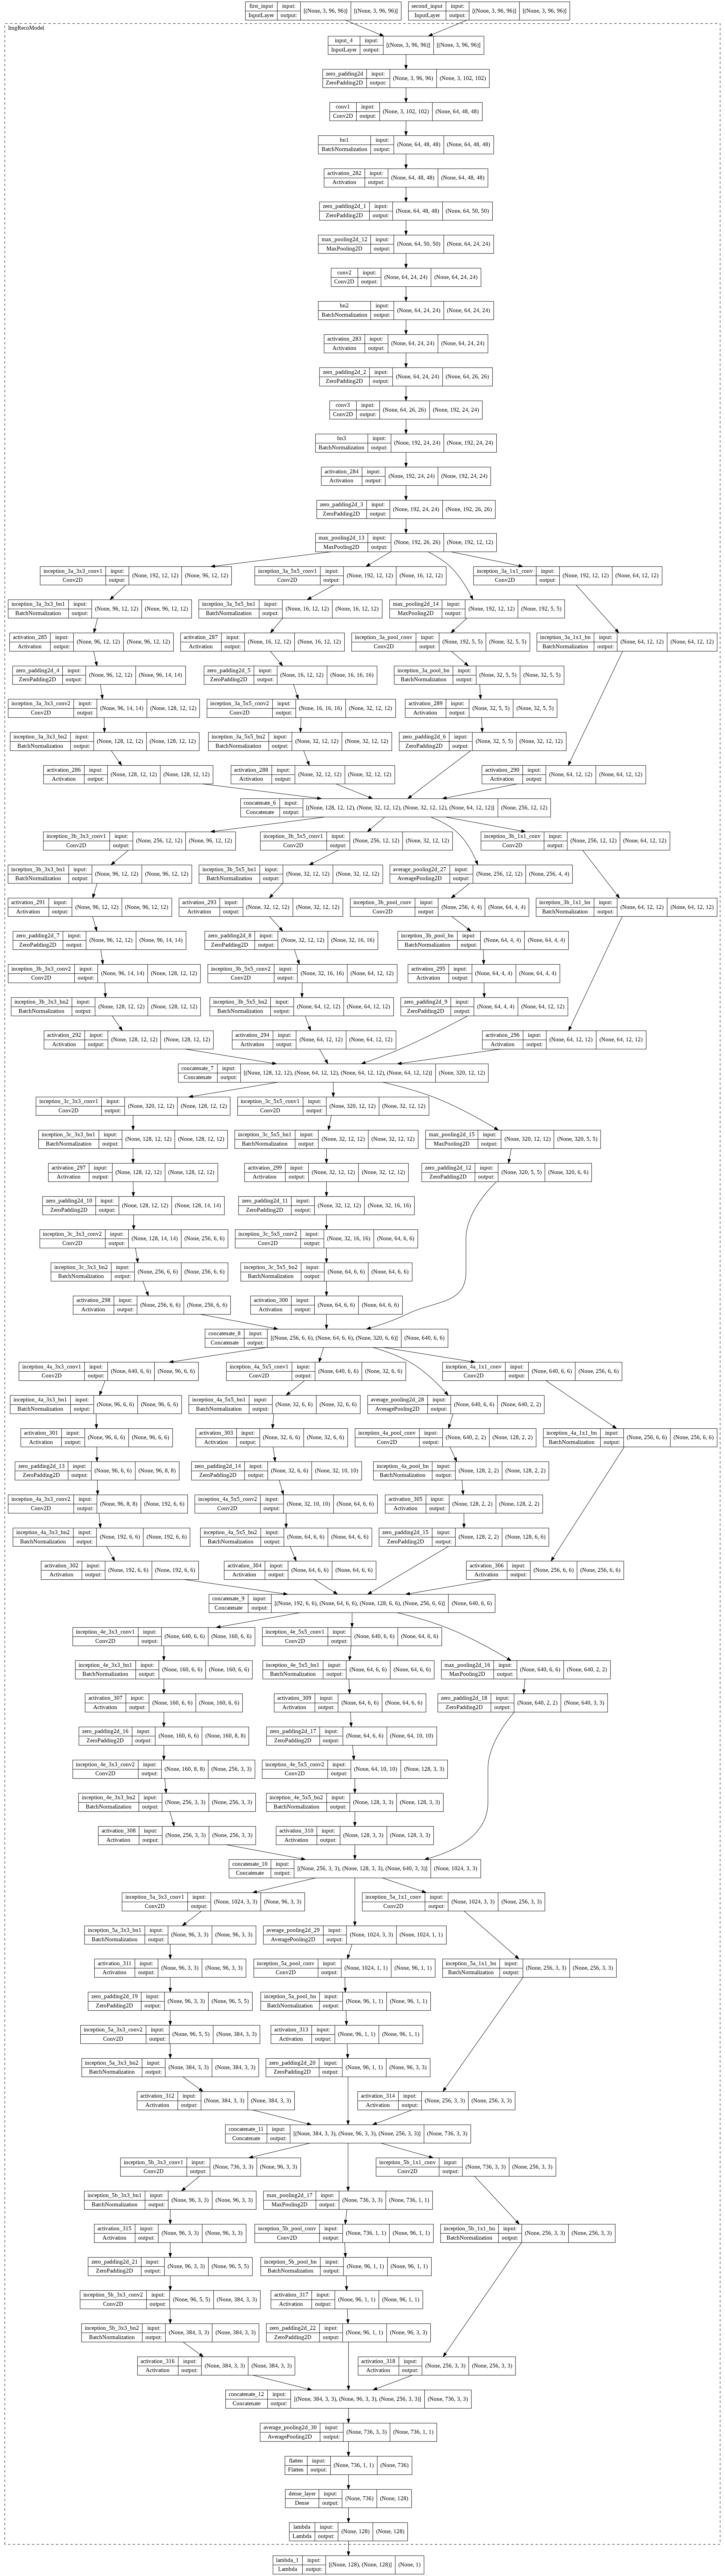

In [68]:
plot_model(siam_network, show_shapes=True, expand_nested=True)

In [69]:
early_stop = EarlyStopping(
    monitor='loss',
    patience=8,
    restore_best_weights=True
)

In [70]:
rms = RMSprop()
siam_network.compile(loss=contrastive_loss_with_margin(margin=2), optimizer=rms)

In [71]:
history = siam_network.fit(train_gen, epochs=200, steps_per_epoch=64, callbacks=[early_stop])

Epoch 1/200
64/64 [==============================] - 28s 84ms/step - loss: 0.4982
Epoch 2/200
64/64 [==============================] - 5s 79ms/step - loss: 0.3901
Epoch 3/200
64/64 [==============================] - 5s 76ms/step - loss: 0.4394
Epoch 4/200
64/64 [==============================] - 5s 75ms/step - loss: 0.3951
Epoch 5/200
64/64 [==============================] - 5s 76ms/step - loss: 0.3671
Epoch 6/200
64/64 [==============================] - 5s 76ms/step - loss: 0.3435
Epoch 7/200
64/64 [==============================] - 5s 77ms/step - loss: 0.3471
Epoch 8/200
64/64 [==============================] - 6s 96ms/step - loss: 0.3346
Epoch 9/200
64/64 [==============================] - 5s 76ms/step - loss: 0.3116
Epoch 10/200
64/64 [==============================] - 5s 75ms/step - loss: 0.3049
Epoch 11/200
64/64 [==============================] - 5s 74ms/step - loss: 0.3079
Epoch 12/200
64/64 [==============================] - 5s 74ms/step - loss: 0.2863
Epoch 13/200
64/64 [====

In [72]:
irm = siam_network.get_layer(index=2)
w = irm.get_weights()
p = imgRecoModel(input_shape)
p.set_weights(w)

In [73]:
p.save('model_siamese_net1_r.h5')

In [74]:
id_real = list(dic_real.keys())
len(id_real)

6000

In [75]:
def compute_distance():
  [anc_pos, neg] = np.random.choice(ids, size=2, replace=False)

  anc_img = dic_real[anc_pos][0]
  pos_img = np.random.choice(dic_data[anc_pos])
  neg_img = np.random.choice(dic_data[neg])

  anc_img = np.around(np.transpose(cv2.resize(cv2.imread(anc_img), (96, 96))/255.0, (2, 0, 1)), decimals=6)
  pos_img = np.around(np.transpose(cv2.resize(cv2.imread(pos_img), (96, 96))/255.0, (2, 0, 1)), decimals=6)
  neg_img = np.around(np.transpose(cv2.resize(cv2.imread(neg_img), (96, 96))/255.0, (2, 0, 1)), decimals=6)

  pos_enc = p.predict_on_batch(np.expand_dims(pos_img, 0))
  anc_enc = p.predict_on_batch(np.expand_dims(anc_img, 0))
  neg_enc = p.predict_on_batch(np.expand_dims(neg_img, 0))

  print('Distance between anchor - positive: ', np.linalg.norm(anc_enc - pos_enc))
  print('Distance between anchor - negative: ', np.linalg.norm(anc_enc - neg_enc))

  fig, ax = plt.subplots(1, 3, figsize=(10, 4))
  ax[0].imshow(np.transpose(anc_img, (1, 2, 0)))
  ax[0].title.set_text('Anchor Image')
  ax[1].imshow(np.transpose(pos_img, (1, 2, 0)))
  ax[1].title.set_text('Positive Image')
  ax[2].imshow(np.transpose(neg_img, (1, 2, 0)))
  ax[2].title.set_text('Negative Image')
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

Distance between anchor - positive:  0.044466216
Distance between anchor - negative:  1.2670392


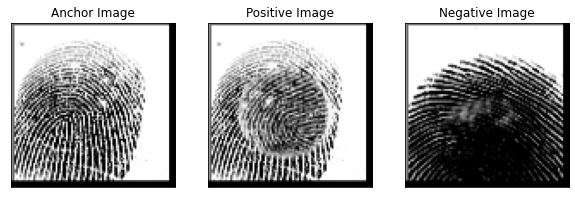

In [79]:
# Every time you run this cell you will get different image set
compute_distance()